In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, average_precision_score, precision_recall_curve, f1_score, recall_score, precision_score
df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
df.rename(columns = {'PAY_0':'PAY_1'}, inplace = True)
# Split into 2 data sets with stratification on the default status
df1, df2 = train_test_split(
    df,
    test_size=0.3,
    stratify=df['default.payment.next.month'],
    shuffle=True,
    random_state=42
)
# Reset ID starting from 1
df1['ID'] = range(1, len(df1) + 1)
df2['ID'] = range(1, len(df2) + 1)
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
# Save new data sets
df1.to_csv('/kaggle/working/dataset_1.csv', index=False)
df2.to_csv('/kaggle/working/dataset_2.csv', index=False)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_1                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [53]:
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

<Axes: ylabel='count'>

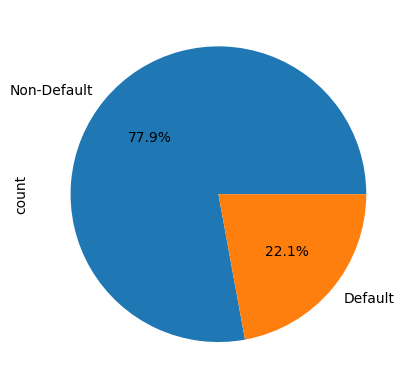

In [54]:
df['default.payment.next.month'].value_counts().plot.pie(labels=['Non-Default', 'Default'], autopct='%1.1f%%')

The ratio of default:non-default is quite asymmetric, but not too extreme. Therefore, I'm curious about the effectiveness of the Complementary Log-log regression in this case. I will put it at the end of my assignment. 

In [55]:
df1.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,10500.500000,167499.142857,1.603571,1.856857,1.553333,35.428048,-0.01519,-0.133857,-0.165810,-0.220143,...,43314.444238,40325.764524,38837.678000,5654.306714,5.912902e+03,5252.244524,4876.201381,4819.560000,5234.141429,0.221190
std,6062.322162,129767.049797,0.489167,0.795234,0.522017,9.184785,1.12346,1.199845,1.194393,1.161867,...,64429.078267,61008.873612,59553.243817,16424.968267,2.070229e+04,18016.514345,15459.063612,15156.022121,17650.268320,0.415058
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-81334.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5250.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,2390.250000,1751.250000,1239.750000,1000.000000,8.855000e+02,390.000000,300.000000,248.750000,100.000000,0.000000
50%,10500.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.00000,0.000000,0.000000,0.000000,...,18984.000000,18100.000000,17032.000000,2118.500000,2.015000e+03,1821.500000,1500.000000,1508.500000,1500.000000,0.000000
75%,15750.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.00000,0.000000,0.000000,0.000000,...,54647.750000,50232.000000,49054.750000,5021.250000,5.000000e+03,4600.000000,4092.250000,4057.000000,4000.000000,0.000000
max,21000.000000,1000000.000000,2.000000,6.000000,3.000000,75.000000,8.00000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.215471e+06,896040.000000,621000.000000,426529.000000,527143.000000,1.000000


In [56]:
df2.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,...,9000.000000,9000.000000,9000.000000,9000.000000,9.000000e+03,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4500.500000,167449.742222,1.604111,1.844444,1.548444,35.619556,-0.020222,-0.133556,-0.167111,-0.221889,...,43142.793333,40277.886000,38951.286000,5685.219333,5.940439e+03,5163.701111,4709.119667,4752.318778,5172.011889,0.221222
std,2598.220545,129709.612954,0.489068,0.778805,0.521872,9.293855,1.124652,1.191026,1.202687,1.185997,...,64111.187885,60303.617469,59559.355832,16882.505358,2.774254e+04,16612.924624,16139.321857,15560.646669,18071.693753,0.415093
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-53007.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2250.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2247.500000,1800.000000,1300.000000,882.750000,7.800000e+02,391.750000,273.750000,263.250000,175.000000,0.000000
50%,4500.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19221.000000,18128.000000,17162.000000,2081.000000,2.000000e+03,1781.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,6750.250000,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,...,53970.000000,50094.500000,49539.000000,5000.000000,5.000000e+03,4403.250000,4000.000000,4013.250000,4070.250000,0.000000
max,9000.000000,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,...,706864.000000,551702.000000,568638.000000,493358.000000,1.684259e+06,417588.000000,528897.000000,388071.000000,528666.000000,1.000000


The statistical characteristics of default.payment.next.month are highly similar across the two datasets, indicating their suitability for use as training and testing sets, respectively.

In [57]:
# Train and Test Set
X_train = df1.drop(columns=['ID', 'default.payment.next.month'])
y_train = df1['default.payment.next.month']
X_test = df2.drop(columns=['ID', 'default.payment.next.month'])
y_test = df2['default.payment.next.month']

In [58]:
#Multicollinearity Test
def compute_vif(X):
    X = X.loc[:, X.std() != 0]
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
vif_df = compute_vif(X_train)
print("Initial VIF values:")
print(vif_df.sort_values(by="VIF", ascending=False))

Initial VIF values:
      feature        VIF
12  BILL_AMT2  40.759546
13  BILL_AMT3  36.704390
15  BILL_AMT5  34.824844
14  BILL_AMT4  30.066280
16  BILL_AMT6  21.183721
11  BILL_AMT1  20.739864
4         AGE  10.838654
1         SEX   9.072263
2   EDUCATION   6.646191
3    MARRIAGE   6.275724
9       PAY_5   4.934090
8       PAY_4   4.395796
0   LIMIT_BAL   4.045637
7       PAY_3   3.715421
10      PAY_6   3.420583
6       PAY_2   3.221916
18   PAY_AMT2   2.427250
19   PAY_AMT3   1.995157
17   PAY_AMT1   1.933801
5       PAY_1   1.900081
21   PAY_AMT5   1.828546
20   PAY_AMT4   1.776787
22   PAY_AMT6   1.281638


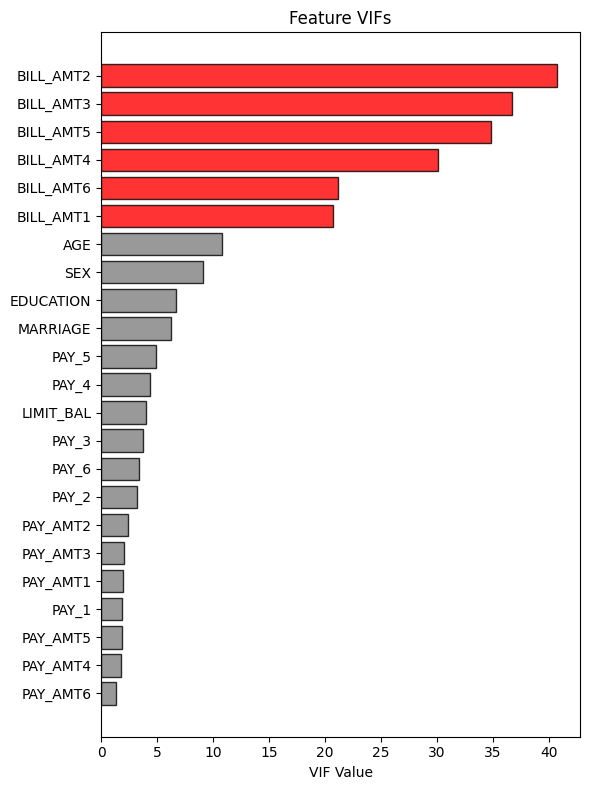

In [59]:
vif_sorted = vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)
bill_cols = {"BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"}
colors = [
    "red" if feat in bill_cols else "gray"
    for feat in vif_sorted["feature"]
]
plt.figure(figsize=(6, 8))
plt.barh(
    y=vif_sorted["feature"],
    width=vif_sorted["VIF"],
    color=colors,
    edgecolor="black",
    alpha=0.8
)
plt.gca().invert_yaxis()  
plt.xlabel("VIF Value")
plt.title("Feature VIFs")
plt.tight_layout()
plt.show()

Several variables related to BILL\_ATM (Amount of bill statement) exhibit extremely high Variance Inflation Factors (VIF), indicating significant multicollinearity. To address this issue, I will apply Principal Component Analysis (PCA) to consolidate these variables into a single composite feature, rather than removing them individually.

In [60]:
from sklearn.decomposition import PCA
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train[bill_amt_cols])
X_test_pca = pca.transform(X_test[bill_amt_cols])
X_train_reduced = X_train.drop(columns=bill_amt_cols)
X_train_reduced['BILL_AMT_PCA'] = X_train_pca
X_test_reduced = X_test.drop(columns=bill_amt_cols)
X_test_reduced['BILL_AMT_PCA'] = X_test_pca

In [61]:
#Logit Model
X_train_sm = sm.add_constant(X_train_reduced)
X_test_sm = sm.add_constant(X_test_reduced)
logit_model = sm.Logit(y_train, X_train_sm)
logit_result = logit_model.fit(method = 'newton', maxiter = 100, disp = True)
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.463570
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                21000
Model:                                  Logit   Df Residuals:                    20981
Method:                                   MLE   Df Model:                           18
Date:                        Wed, 04 Jun 2025   Pseudo R-squ.:                  0.1227
Time:                                03:37:30   Log-Likelihood:                -9735.0
converged:                               True   LL-Null:                       -11097.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7032      0.144     -

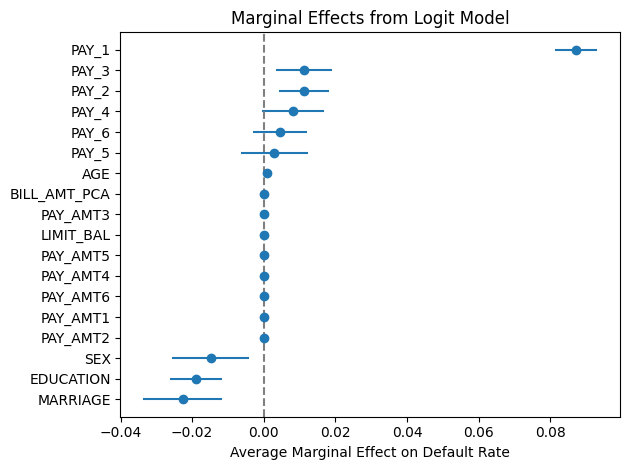

In [62]:
#Marginal Effects
mfx = logit_result.get_margeff()
mfx_summary = mfx.summary_frame()
mfx_summary = mfx_summary.sort_values(by = 'dy/dx')
vars_ = mfx_summary.index
effects = mfx_summary['dy/dx']
lower = mfx_summary['dy/dx'] - 1.96 * mfx_summary['Std. Err.']
upper = mfx_summary['dy/dx'] + 1.96 * mfx_summary['Std. Err.']
plt.errorbar(effects, vars_, xerr=[effects - lower, upper - effects], fmt='o')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Average Marginal Effect on Default Rate')
plt.title('Marginal Effects from Logit Model')
plt.tight_layout()
plt.show()

Based on the plot, repayment status each month, especially in September 2005 (the most recent month), education, and marital status seem to have some clear impacts on credit default rate. More specifically, the longer a client has delayed his/her payment, the higher chance he/she will default. In addition to that, people with higher education (1 = graduate school, 2=university, 3=high school) are more likely to default, which is quite counterintuitive. Finally, single clients seem to default on their payment less often than married clients(with 1=married, 2=single). 

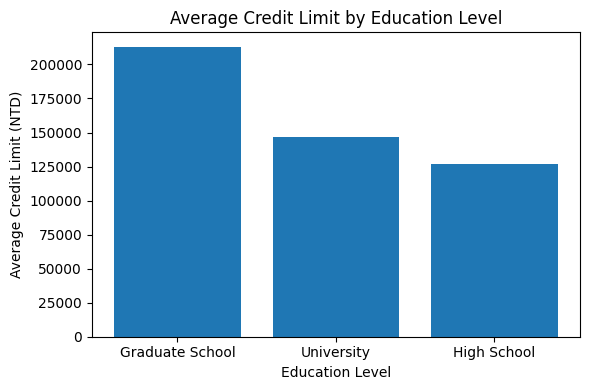

In [76]:
#Further Investigation on the Effects of Education Level
avg_limits = df.groupby('EDUCATION')['LIMIT_BAL'].mean().loc[[1, 2, 3]]
mapping = {1: 'Graduate School', 2: 'University', 3: 'High School'}
labels = [mapping[i] for i in avg_limits.index]
plt.figure(figsize=(6, 4))
plt.bar(labels, avg_limits.values)
plt.xlabel('Education Level')
plt.ylabel('Average Credit Limit (NTD)')
plt.title('Average Credit Limit by Education Level')
plt.tight_layout()
plt.show()

As shown on the graph, I suggested following findings: 
1. Potential multicollinearity between Credit Limit and Education:
- Higher education levels are associated with larger credit limits.
- Larger limits may lead to higher spending and larger monthly payments, increasing default risk over time.
2. Graduate students may lack stable income:
- They might still be in school, relying on limited or no income.
- In contrast, high school graduates may have been in the workforce longer and built more financial stability.

In [63]:
# Model evaluation, threshold = 0.5
y_proba = logit_result.predict(X_test_sm)
y_pred = (y_proba >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8077777777777778
ROC AUC: 0.7142593590116861
PR AUC: 0.4968097389446754
Confusion Matrix:
 [[6807  202]
 [1528  463]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.23      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



The model achieves high recall (0.97) for the negative class (non-defaults), meaning it correctly identifies most non-default cases. However, it has a low recall (0.23) for the positive class (defaults), indicating it misses a large portion of actual defaults. 
Additionally, since 78% of cases are non-defaults, the model’s accuracy of ~81% is only marginally better than a naive classifier that predicts all cases as non-default. The large number of false negatives (1528) confirms that many defaults are missed. As a result, this highlights the challenge of dealing with imbalanced data and the importance of metrics beyond accuracy.
Finally, F1-score for positive class is only 0.35, indicating that the harmonic mean of precision and recall for defaults is low, reinforcing the limited ability to balance catching defaults and avoiding false alarms. 

In [64]:
# Find optimal threshold:
best_accuracy = best_f1 = best_recall = best_precision = best_j = 0
best_accuracy_th = best_f1_th = best_recall_th = best_precision_th = best_auc_th = 0
thresholds = np.arange(0.0, 1.001, 0.001)
for th in thresholds:
    y_pred_th = (y_proba >= th).astype(int)
    acc = accuracy_score(y_test, y_pred_th)
    f1 = f1_score(y_test, y_pred_th)
    rec = recall_score(y_test, y_pred_th)
    prec = precision_score(y_test, y_pred_th, zero_division=0)
    if acc > best_accuracy:
        best_accuracy = acc
        best_accuracy_th = th
    if f1 > best_f1:
        best_f1 = f1
        best_f1_th = th
    if rec > best_recall:
        best_recall = rec
        best_recall_th = th
    if prec > best_precision:
        best_precision = prec
        best_precision_th = th
print("Optimal Thresholds for Each Metric:")
print(f"  Accuracy:  threshold = {best_accuracy_th:.4f}, score = {best_accuracy:.4f}")
print(f"  F1 Score:  threshold = {best_f1_th:.4f}, score = {best_f1:.4f}")
print(f"  Recall:    threshold = {best_recall_th:.4f}, score = {best_recall:.4f}")
print(f"  Precision: threshold = {best_precision_th:.4f}, score = {best_precision:.4f}")

Optimal Thresholds for Each Metric:
  Accuracy:  threshold = 0.4330, score = 0.8144
  F1 Score:  threshold = 0.2740, score = 0.5096
  Recall:    threshold = 0.0000, score = 1.0000
  Precision: threshold = 0.9930, score = 1.0000


These results highlight the classic tradeoff between recall and precision when selecting classification thresholds: at a very low threshold (0.0000), the model predicts all instances as positive, achieving perfect recall by capturing all actual positives but generating many false positives and thus very low precision; conversely, at a very high threshold (0.9930), the model is extremely conservative, predicting positive only when highly confident, resulting in perfect precision with no false positives but missing many true positives, leading to low recall.

In [65]:
#My own hypothesis
annualIR = 0.04 
LGD = 0.5
average_loan = df['LIMIT_BAL'].mean()
reputation_factor = 1.12
operation_cost = 3000 #New Taiwan dollars
loan_term = 5 #years
interest_per_loan = annualIR * average_loan
FP_cost = (interest_per_loan * loan_term  + operation_cost) * reputation_factor
FN_cost = LGD * average_loan + interest_per_loan * loan_term
results = []
for thresh in thresholds:
    y_pred = (y_proba>= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_alarms = fp / (fp + tp) if (fp + tp) > 0 else 0
    missed_defaults = fn / (fn + tn) if (fn + tn) > 0 else 0
    total_cost = fn * FN_cost + fp * FP_cost
    results.append({
        'threshold': thresh,
        'false_alarms': false_alarms,
        'missed_defaults': missed_defaults,
        'total_cost': total_cost
    })

For the aforementioned formulas, I proposed following assumptions:
1. annualIR (Annual Interest Rate = 0.04):
I referred this rate from annual interest rate in Taiwan in 2005, corresponding to the time and location of this data set. 
2. LGD (Loss Given Default = 0.5):
This is the proportion of the loan amount the lender expects to lose if the borrower defaults. I couldn't find a source for this rate, so I decided to use a typical rate of 50%.
3. average_loan:
This is the average loan amount issued to borrowers, calculated from the dataset (LIMIT_BAL). 
4. reputation_factor (1.12):
This multiplier accounts for indirect costs related to damaging the lender’s reputation due to false positives—when good borrowers are wrongly classified as risky. It could represent lost future business or customer trust. I chose 1.12 because I expect typical reputational risk for financial institutions to be 12%. 
5. operation_cost (3000 NTD):
This is a fixed cost per loan, covering administrative expenses such as loan processing, monitoring, and management. I simply chose a reasonable number (approximately $100 if you don't want to do the currency conversion). 
6. loan_term (5 years):
The duration over which the loan is repaid and interest accrues. Again, I simply chose a typical number. 
7. interest_per_loan:
Calculated as annualIR * average_loan, this estimates the interest earned per year on an average loan.
8. FP_cost (False Positive Cost):
Represents the total cost when a non-default borrower is incorrectly flagged as default. It includes lost interest income over the loan term plus operational costs, all inflated by the reputation factor.
9. FN_cost (False Negative Cost):
Represents the cost of failing to identify a defaulting borrower. This includes the expected financial loss from the default (LGD × loan amount) plus the lost interest income over the loan term.

Because my cost function is mostly based on intuitive assumptions, it's quite risky to solely find the optimal threshold by minimizing the cost. I want to follow a more balanced approach by considering both the risk of false alarms and risk of missed defaults. 

In [66]:
metrics = np.array([
    [r['false_alarms'], r['missed_defaults'], r['total_cost']] 
    for r in results
])
scaler = MinMaxScaler()
normalized = scaler.fit_transform(metrics)
weights = np.array([1.0, 1.0, 1.0])  # [false_alarms, missed_defaults, cost]
combined_score = normalized @ weights
optimal_idx = np.argmin(combined_score)
optimal = results[optimal_idx]
print(f"""
Optimal Threshold: {optimal['threshold']:.3f}
False Alarm Rate: {optimal['false_alarms']:.1%}
Missed Default Rate: {optimal['missed_defaults']:.1%}
Total Cost: NT${optimal['total_cost']:,.2f}
""")


Optimal Threshold: 0.289
False Alarm Rate: 44.9%
Missed Default Rate: 14.4%
Total Cost: NT$154,570,482.69



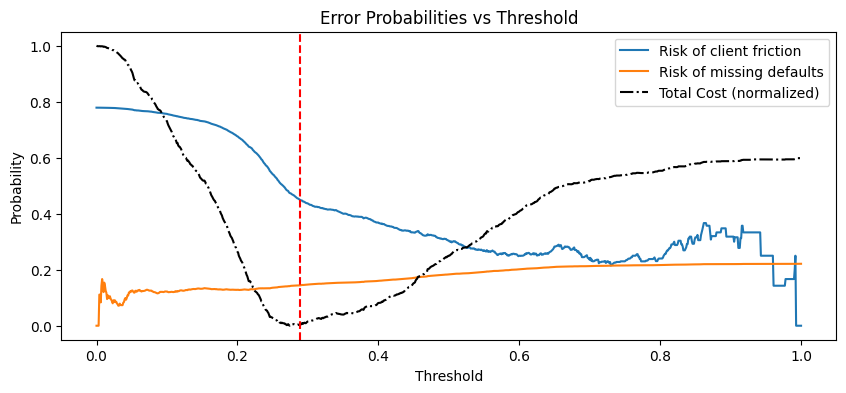

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, [r['false_alarms'] for r in results], label='Risk of client friction')
plt.plot(thresholds, [r['missed_defaults'] for r in results], label='Risk of missing defaults')
plt.plot(thresholds, normalized[:, 2], label='Total Cost (normalized)', color='black', linestyle='-.')
plt.axvline(optimal['threshold'], color='red', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Probability')
plt.legend()
plt.title('Error Probabilities vs Threshold')
plt.show()

According to my estimations, the optimal threshold might be 0.289. Although the percentage of false alarms is quite high (44.9%), the percentage of missed defaults has improved (14.2%). Intuitively, I also expect the cost of missed defaults to be significantly higher than the cost of false alarms. 

In [68]:
y_pred_mod = (y_proba >= 0.289).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_mod))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mod))
print("Classification Report:\n", classification_report(y_test, y_pred_mod))

Accuracy: 0.798
ROC AUC: 0.7142593590116861
PR AUC: 0.4968097389446754
Confusion Matrix:
 [[6242  767]
 [1051  940]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      7009
           1       0.55      0.47      0.51      1991

    accuracy                           0.80      9000
   macro avg       0.70      0.68      0.69      9000
weighted avg       0.79      0.80      0.79      9000



Overall, accuracy slightly drops from 80.8% to 79.8%, and recall for non-default class also decreased from 0.97 to 0.89. However, for default class, recall has improved from 0.23 to 0.47, and f1 score increased from 0.35 to 0.51. The new threshold adjustment catches more actual defaults but at the expense of more false alarms. This tradeoff is often desirable in credit risk contexts where missing defaults (false negatives) can be more costly than flagging some safe borrowers (false positives). 

In [69]:
#Complementary log-log Regression
cloglog_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial(link=sm.families.links.cloglog()))
cloglog_result = cloglog_model.fit()
print(cloglog_result.summary())
y_proba_cloglog = cloglog_result.predict(X_test_sm)
threshold = 0.289
y_pred_cloglog = (y_proba_cloglog >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_cloglog))
print("ROC AUC:", roc_auc_score(y_test, y_proba_cloglog))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cloglog))
print("Classification Report:\n", classification_report(y_test, y_pred_cloglog))

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


                     Generalized Linear Model Regression Results                      
Dep. Variable:     default.payment.next.month   No. Observations:                21000
Model:                                    GLM   Df Residuals:                    20981
Model Family:                        Binomial   Df Model:                           18
Link Function:                        cloglog   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -9910.2
Date:                        Wed, 04 Jun 2025   Deviance:                       19820.
Time:                                03:37:47   Pearson chi2:                 2.19e+04
No. Iterations:                           100   Pseudo R-squ. (CS):             0.1068
Covariance Type:                    nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

Under the same threshold, cloglog do not outperform normal logit in any evaluation metrics. Therefore, I suppose cloglog is only designated for extremely rare case detection. 

For classification tasks, I particularly find model calibration to be quite interesting, especially in ensuring accurate probability. Therefore, I want to use this test to compare between normal logit and cloglog, although I guess there won't be much difference between those two models.

In [70]:
#Model Calibration
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
brier_logit = brier_score_loss(y_test, y_proba)
brier_cloglog = brier_score_loss(y_test, y_proba_cloglog)
print(f"Brier score (Logit): {brier_logit:.4f}")
print(f"Brier score (Cloglog): {brier_cloglog:.4f}")
log_loss_logit = log_loss(y_test, y_proba)
log_loss_cloglog = log_loss(y_test, y_proba_cloglog)
print(f"Log Loss (Logit): {log_loss_logit:.4f}")
print(f"Log Loss (Cloglog): {log_loss_cloglog:.4f}")

Brier score (Logit): 0.1463
Brier score (Cloglog): 0.1508
Log Loss (Logit): 0.4699
Log Loss (Cloglog): 0.4753


The logit model performs slightly better than the cloglog model on both Brier score and log loss, suggesting that its predicted probabilities are marginally more accurate and better calibrated overall. However, the differences are quite small, indicating that both models produce comparable probability estimates. This aligns with expectations, as the choice between logit and cloglog often makes only subtle differences unless the outcome distribution is highly skewed or asymmetric.

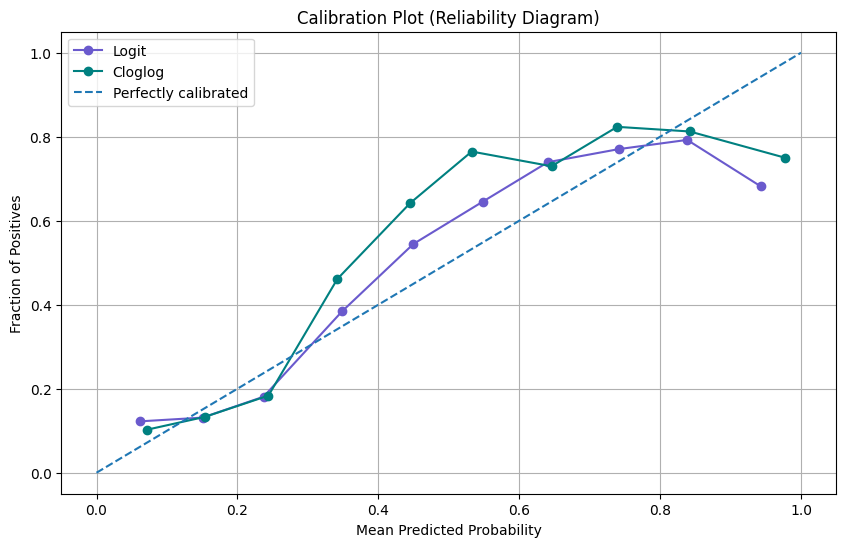

In [71]:
prob_true_logit, prob_pred_logit = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')
prob_true_cloglog, prob_pred_cloglog = calibration_curve(y_test, y_proba_cloglog, n_bins=10, strategy='uniform')
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_logit, prob_true_logit, marker='o', color = 'slateblue', label='Logit')
plt.plot(prob_pred_cloglog, prob_true_cloglog, marker='o', color = 'teal', label='Cloglog')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

The calibration plot shows that both models are reasonably well calibrated, but the logit model aligns slightly better with the ideal diagonal line. The cloglog model tends to overestimate probabilities in the middle range. This supports the earlier findings from the Brier score and log loss. Additionally, this observation quite aligns with cloglog's ability in detecting extreme events and working with highly-asymmetric probability distribution. 

* BONUS PART:
I still concerned about multicollinearity in the modified logit model, so I tried the regularized logit model as well. However, there is no difference between the final results, so eventually I didn't continue with it. Below is what I did. 

In [72]:
#Search for the most suitable regularization:
scaler_1 = StandardScaler()
X_train_scaled = scaler_1.fit_transform(X_train_reduced)
model = LogisticRegression(
    penalty='elasticnet', 
    solver='saga', 
    max_iter=200,
    random_state=42
)
param_grid = {
    'C': [0.1, 1, 10],    
    'l1_ratio': [0.0, 0.5, 1.0]   
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs =-1
)
grid_search.fit(X_train_scaled, y_train)
print("Best params:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Best params: {'C': 10, 'l1_ratio': 0.0}
Best ROC AUC: 0.724635122429913


l1_ratio = 0 means that I should use l2 (Ridge) penalty. From my own understanding, all variables contribute to the model, so there is no need for feature selection. L2 can deal with multicollinearity by shrinking coefficients towards zero smoothly. 

In [73]:
reg_model = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=200,
    random_state=42
)
reg_model.fit(X_train_scaled, y_train)
X_test_scaled = scaler_1.transform(X_test_reduced)
y_proba_reg = reg_model.predict_proba(X_test_scaled)[:, 1]
y_pred_reg = (y_proba >= 0.289).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_reg))
print("ROC AUC:", roc_auc_score(y_test, y_proba_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_reg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_reg))

Accuracy: 0.798
ROC AUC: 0.7142549877931932
Confusion Matrix:
 [[6242  767]
 [1051  940]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      7009
           1       0.55      0.47      0.51      1991

    accuracy                           0.80      9000
   macro avg       0.70      0.68      0.69      9000
weighted avg       0.79      0.80      0.79      9000



P/S: Because this assignment is related to logit-probit model, I only compared different variants of the logit model. I hope I will be able to test some Machine Learning approaches such as Random Forest and SVM in the near future. 